In [1]:
'''
In this notebook we train our model. The thickness and number of hidden layers were tuned manually, 
but otherwise nothing else has. Once could e.g. change the activation function from tanh to relu.

The FunctionScalar package (https://github.com/weissercn/FunctionScaler/) is used to preprocess the data. 
Installing this package can be done using pip (pip install FunctionScaler)
'''

'\nIn this notebook we train our model. The thickness and number of hidden layers were tuned manually, \nbut otherwise nothing else has. Once could e.g. change the activation function from tanh to relu.\n\nThe FunctionScalar package (https://github.com/weissercn/FunctionScaler/) is used to preprocess the data. \nInstalling this package can be done using pip (pip install FunctionScaler)\n'

In [26]:
# Importing necessary libraries
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
# from __future__ import print_function
# from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split


plt.rc('text', usetex=False)
%matplotlib inline

In [3]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.visible_device_list = '1'

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

tf.set_random_seed(1)
sess = tf.Session(config=config)
set_session(sess)

from Autoencoder_Utils import *

/opt/conda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Считаем подготовленные для обучения автоэнкодера данные

In [4]:
# Loading the data
TYPE = "" # 100% of the data. To determine the real performance of the cross check
# TYPE = "_10perc" # 10% of the data. Used for everything except to determine the real performance of the cross check
# TYPE = "_1perc" # 1% of the data. For small tests.
# TYPE = "_100" # 100 samples of the data. For very rudimentary tests

df = pd.read_csv('Data/Df_example{}.csv'.format(TYPE))

In [5]:
# How many samples of each particle do we have
print(df['pid'].value_counts())

f    454948
e    450775
a    438012
c    408195
d    377725
b    358002
Name: pid, dtype: int64


In [6]:
pids_no = df['pid'].value_counts().to_dict()
n_samples = np.shape(df.as_matrix())[0]

In [7]:
# Dividing the variables into compressable, auxiliary and simulation truth variables not seen in real datasets
vars_list = list(df)
vars_list_input, vars_list_aux, vars_list_MC = [], [], []

for v in vars_list:
    if v == 'pid': 
        vars_list_MC.append(v)
    elif 'aux' in v: 
        vars_list_aux.append(v)
    else: 
        vars_list_input.append(v)

print("{} variables to compress".format(len(vars_list_input)))

18 variables to compress


CPU times: user 11.8 s, sys: 4.88 s, total: 16.7 s
Wall time: 10.7 s


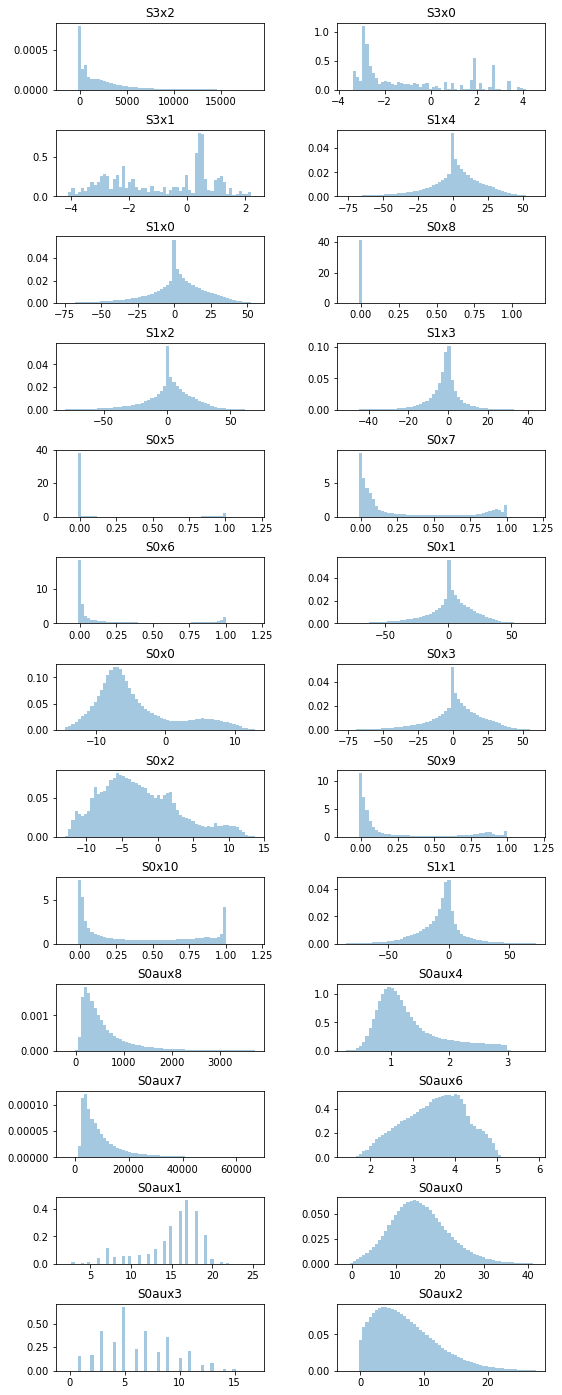

In [25]:
%%time
# Display histograms of our features
print_features_histograms(df[vars_list_input + vars_list_aux], None, save_filename="./img/original_distribs.png")

# Разобъем индексы на train и test

In [12]:
# train test split
train_size = 0.7
test_size = 0.3
idx_train, idx_test = train_test_split(np.arange(df.shape[0], dtype='int32'), random_state=5,
                                       stratify=df['pid'], train_size=train_size, test_size=test_size)

In [16]:
df.shape, idx_train.shape, idx_test.shape

((2487657, 27), (1741359,), (746298,))

## Переведем значения признаков в отрезок $[-1, 1]$

Ранее помимо масштабирования признаков меняли и их распределение на равномерное, но это не имеет смысла, так как энкодер и декодер восстанавливают распределения $P(Z|X)$ и $Q(X|Z)$ соответственно. А по ним уже восстанавливается распределение $P(X)$ каким бы оно не было.

##### Так то оно правильно, но, может быть, автоэнкодеру проще восстановить равномерное распределение, чем произвольное?!

In [10]:
df_scaled = df.copy()

In [27]:
%%time
scalers = {}

for var in (vars_list_input + vars_list_aux):
    # normalize with StandardScaler
    std_scaler = StandardScaler()
    std_scaler.fit(df[var].iloc[idx_train].values.reshape(-1, 1))
    df_scaled[var] = std_scaler.transform(df[var].values.reshape(-1, 1))
    
    max_scaler = MaxAbsScaler()
    max_scaler.fit(df_scaled[var].iloc[idx_train].values.reshape(-1, 1))
    df_scaled[var] = max_scaler.transform(df_scaled[var].values.reshape(-1, 1))
    scalers[var] = {
        'std': std_scaler,
        'max': max_scaler
    }

CPU times: user 7.71 s, sys: 504 ms, total: 8.22 s
Wall time: 8.15 s


CPU times: user 12 s, sys: 4.83 s, total: 16.9 s
Wall time: 10.7 s


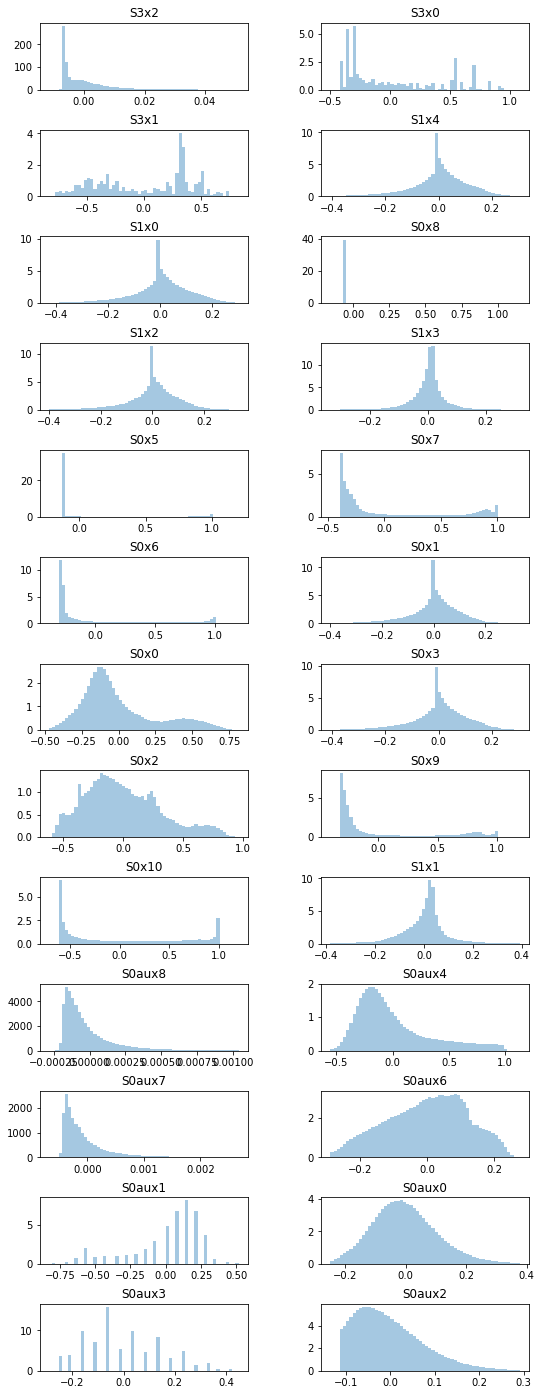

In [28]:
%%time
# Display histograms of our features
print_features_histograms(df_scaled[vars_list_input + vars_list_aux], None, save_filename="./img/scaled_distribs.png")

## Зададим архитектуру автоэнкодера

In [38]:
def create_autoencoder_aux(n_features, encoding_dim, n_aux_features=5, p_drop=0.5, n_layers=3, thickness=2):
    # Энкодер
    inputs = Input(shape=(n_features, ), name='main_input')
    aux_inputs = Input(shape=(n_aux_features, ), name='aux_inputs')
    
    
    x = keras.layers.concatenate([inputs, aux_inputs])

    for i in range(n_layers - 1):
        x = Dense(thickness * n_features, activation='tanh')(x)
        x = keras.layers.concatenate([x, aux_inputs])

#     x = Dropout(p_drop)(x)
    
    x = Dense(thickness * encoding_dim, activation='tanh')(x)
    x = keras.layers.concatenate([x, aux_inputs])
#     x = Dropout(p_drop)(x)
    encoded = Dense(encoding_dim, activation='tanh', name='encoded')(x)

    
    # Декодер
    input_encoded = Input(shape=(encoding_dim, ))
    
    x = keras.layers.concatenate([input_encoded, aux_inputs])
    x = Dense(thickness * encoding_dim, activation='tanh')(x)
#     x = Dropout(p_drop)(x)
    
    for i in range(n_layers - 1):
        x = keras.layers.concatenate([x, aux_inputs])
        x = Dense(thickness * n_features, activation='tanh')(x)
        
#     x = Dropout(p_drop)(x)
    decoded = Dense(n_features, activation='tanh')(x)
    
    
    # Модели
    encoder = Model([inputs, aux_inputs], encoded, name="encoder")
    decoder = Model([input_encoded, aux_inputs], decoded, name="decoder")
    autoencoder = Model(
        [inputs, aux_inputs], decoder([encoder([inputs, aux_inputs]), aux_inputs]), name="autoencoder"
    )

    optimizer_adam = optimizers.Adam(lr=0.001)
    autoencoder.compile(loss='mse', optimizer=optimizer_adam)
    
    return autoencoder, encoder, decoder

## Обучим автоэнкодер

In [40]:
l_encoding_dim = [1, 3, 6, 9, 12, 15, 18]
l_score = []
val_size = 0.1

train = df_scaled.iloc[idx_train]
test = df_scaled.iloc[idx_test]

train_input = train[vars_list_input].values
train_aux   = train[vars_list_aux].values
train_MC    = train[vars_list_MC].values

test_input = test[vars_list_input].values
test_aux   = test[vars_list_aux].values
test_MC    = test[vars_list_MC].values


  0%|          | 0/7 [00:00<?, ?it/s]

encoding_dim :  1
Train on 1567223 samples, validate on 174136 samples


Epoch 1/30
1567223/1567223 [==============================] - 129s 82us/step - loss: 0.0221 - val_loss: 0.0169
Epoch 2/30
1567223/1567223 [==============================] - 119s 76us/step - loss: 0.0158 - val_loss: 0.0143
Epoch 3/30
1567223/1567223 [==============================] - 128s 82us/step - loss: 0.0136 - val_loss: 0.0132
Epoch 4/30
1567223/1567223 [==============================] - 122s 78us/step - loss: 0.0124 - val_loss: 0.0115
Epoch 5/30
1567223/1567223 [==============================] - 120s 77us/step - loss: 0.0134 - val_loss: 0.0136
Epoch 6/30
1567223/1567223 [==============================] - 122s 78us/step - loss: 0.0132 - val_loss: 0.0127
Epoch 7/30
1567223/1567223 [==============================] - 123s 79us/step - loss: 0.0117 - val_loss: 0.0116
Epoch 00007: early stopping
746298/746298 [==============================] - 13s 17us/step


 14%|█▍        | 1/7 [15:43<1:34:19, 943.25s/it]




encoding_dim :  3
Train on 1567223 samples, validate on 174136 samples
Epoch 1/30
1567223/1567223 [==============================] - 122s 78us/step - loss: 0.0070 - val_loss: 0.0048
Epoch 2/30
1567223/1567223 [==============================] - 117s 75us/step - loss: 0.0044 - val_loss: 0.0041
Epoch 3/30
1567223/1567223 [==============================] - 121s 77us/step - loss: 0.0039 - val_loss: 0.0038
Epoch 4/30
1567223/1567223 [==============================] - 120s 77us/step - loss: 0.0036 - val_loss: 0.0034
Epoch 5/30
1567223/1567223 [==============================] - 119s 76us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 6/30
1567223/1567223 [==============================] - 120s 77us/step - loss: 0.0032 - val_loss: 0.0031
Epoch 7/30
1567223/1567223 [==============================] - 120s 76us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/30
1567223/1567223 [==============================] - 120s 77us/step - loss: 0.0030 - val_loss: 0.0030
Epoch 9/30
1567223/1567223 [==========

 29%|██▊       | 2/7 [45:07<1:39:07, 1189.56s/it]




encoding_dim :  6
Train on 1567223 samples, validate on 174136 samples
Epoch 1/30
1567223/1567223 [==============================] - 123s 78us/step - loss: 0.0018 - val_loss: 9.6268e-04
Epoch 2/30
1567223/1567223 [==============================] - 116s 74us/step - loss: 8.4446e-04 - val_loss: 7.6640e-04
Epoch 3/30
1567223/1567223 [==============================] - 123s 78us/step - loss: 7.2706e-04 - val_loss: 6.6164e-04
Epoch 4/30
1567223/1567223 [==============================] - 117s 75us/step - loss: 6.6541e-04 - val_loss: 6.3577e-04
Epoch 5/30
1567223/1567223 [==============================] - 119s 76us/step - loss: 6.2535e-04 - val_loss: 6.0046e-04
Epoch 6/30
1567223/1567223 [==============================] - 115s 74us/step - loss: 5.9583e-04 - val_loss: 5.7348e-04
Epoch 7/30
1567223/1567223 [==============================] - 122s 78us/step - loss: 5.7216e-04 - val_loss: 5.5951e-04
Epoch 8/30
1567223/1567223 [==============================] - 119s 76us/step - loss: 5.5115e-04 -

 43%|████▎     | 3/7 [1:30:16<1:49:41, 1645.27s/it]




encoding_dim :  9
Train on 1567223 samples, validate on 174136 samples
Epoch 1/30
1567223/1567223 [==============================] - 122s 78us/step - loss: 8.7790e-04 - val_loss: 4.0873e-04
Epoch 2/30
1567223/1567223 [==============================] - 121s 77us/step - loss: 3.3274e-04 - val_loss: 2.6347e-04
Epoch 3/30
1567223/1567223 [==============================] - 122s 78us/step - loss: 2.4896e-04 - val_loss: 2.2469e-04
Epoch 4/30
1567223/1567223 [==============================] - 121s 77us/step - loss: 2.1355e-04 - val_loss: 2.0325e-04
Epoch 5/30
1567223/1567223 [==============================] - 125s 80us/step - loss: 1.8948e-04 - val_loss: 1.8257e-04
Epoch 6/30
1567223/1567223 [==============================] - 120s 77us/step - loss: 1.7383e-04 - val_loss: 1.5989e-04
Epoch 7/30
1567223/1567223 [==============================] - 120s 77us/step - loss: 1.6244e-04 - val_loss: 1.5645e-04
Epoch 8/30
1567223/1567223 [==============================] - 120s 76us/step - loss: 1.5267e-

 57%|█████▋    | 4/7 [2:02:05<1:26:13, 1724.49s/it]




encoding_dim :  12
Train on 1567223 samples, validate on 174136 samples
Epoch 1/30
1567223/1567223 [==============================] - 123s 78us/step - loss: 5.9001e-04 - val_loss: 2.9048e-04
Epoch 2/30
1567223/1567223 [==============================] - 120s 76us/step - loss: 2.3322e-04 - val_loss: 1.9539e-04
Epoch 3/30
1567223/1567223 [==============================] - 125s 80us/step - loss: 1.6600e-04 - val_loss: 1.4524e-04
Epoch 4/30
1567223/1567223 [==============================] - 119s 76us/step - loss: 1.3220e-04 - val_loss: 1.4754e-04
Epoch 5/30
1567223/1567223 [==============================] - 125s 79us/step - loss: 1.1155e-04 - val_loss: 1.0321e-04
Epoch 6/30
1567223/1567223 [==============================] - 122s 78us/step - loss: 9.0810e-05 - val_loss: 7.8256e-05
Epoch 7/30
1567223/1567223 [==============================] - 125s 80us/step - loss: 8.1059e-05 - val_loss: 7.6180e-05
Epoch 8/30
1567223/1567223 [==============================] - 119s 76us/step - loss: 7.3667e

 71%|███████▏  | 5/7 [3:04:18<1:17:34, 2327.16s/it]




encoding_dim :  15
Train on 1567223 samples, validate on 174136 samples
Epoch 1/30
1567223/1567223 [==============================] - 126s 80us/step - loss: 4.2642e-04 - val_loss: 1.4054e-04
Epoch 2/30
1567223/1567223 [==============================] - 121s 77us/step - loss: 1.1775e-04 - val_loss: 8.1189e-05
Epoch 3/30
1567223/1567223 [==============================] - 121s 77us/step - loss: 8.3561e-05 - val_loss: 9.2177e-05
Epoch 4/30
1567223/1567223 [==============================] - 122s 78us/step - loss: 6.5774e-05 - val_loss: 6.3916e-05
Epoch 5/30
1567223/1567223 [==============================] - 122s 78us/step - loss: 5.5614e-05 - val_loss: 4.8949e-05
Epoch 6/30
1567223/1567223 [==============================] - 122s 78us/step - loss: 4.8269e-05 - val_loss: 3.7174e-05
Epoch 7/30
1567223/1567223 [==============================] - 123s 78us/step - loss: 4.3484e-05 - val_loss: 3.6961e-05
Epoch 8/30
1567223/1567223 [==============================] - 121s 77us/step - loss: 4.0126e

 86%|████████▌ | 6/7 [3:30:10<34:54, 2094.51s/it]  




encoding_dim :  18
Train on 1567223 samples, validate on 174136 samples
Epoch 1/30
1567223/1567223 [==============================] - 120s 77us/step - loss: 4.1082e-04 - val_loss: 1.7079e-04
Epoch 2/30
1567223/1567223 [==============================] - 123s 78us/step - loss: 1.1284e-04 - val_loss: 8.2098e-05
Epoch 3/30
1567223/1567223 [==============================] - 119s 76us/step - loss: 7.1011e-05 - val_loss: 5.4903e-05
Epoch 4/30
1567223/1567223 [==============================] - 124s 79us/step - loss: 5.6552e-05 - val_loss: 5.0483e-05
Epoch 5/30
1567223/1567223 [==============================] - 119s 76us/step - loss: 4.8488e-05 - val_loss: 4.9606e-05
Epoch 6/30
1567223/1567223 [==============================] - 124s 79us/step - loss: 4.2988e-05 - val_loss: 5.0854e-05
Epoch 7/30
1567223/1567223 [==============================] - 119s 76us/step - loss: 3.9087e-05 - val_loss: 6.0549e-05
Epoch 8/30
1567223/1567223 [==============================] - 123s 79us/step - loss: 3.6064e

100%|██████████| 7/7 [4:00:06<00:00, 2004.92s/it]




CPU times: user 4h 48min 8s, sys: 1h 3min 31s, total: 5h 51min 40s
Wall time: 4h 6s


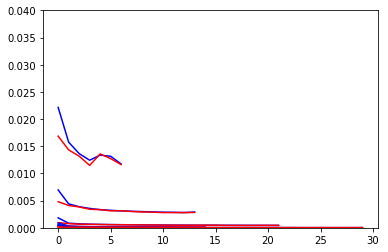

In [43]:
%%time
nb_epoch = 30
batch_size = 128
n_layers = 4
thickness = 6

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=3, mode='min')
tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True) # you can try to run this visualization

save_decoded_dict = {}
save_encoded_dict = {}
    
for encoding_dim in tqdm(l_encoding_dim):
    print("encoding_dim : ", encoding_dim)

    autoencoder, encoder, decoder = create_autoencoder_aux(
        train_input.shape[1], encoding_dim, 
        n_aux_features=train_aux.shape[1], n_layers=n_layers, thickness=thickness
    )

    history = autoencoder.fit(
        [train_input, train_aux], train_input,
        epochs=nb_epoch, batch_size=batch_size,
        shuffle=True, verbose=1,
        validation_split=val_size, callbacks =[early_stopping, tensorboard]
    )

    score = autoencoder.evaluate([test_input, test_aux], test_input, batch_size=batch_size)
    # print ("\n\nscore : ", score)
    l_score.append(score)

    encoded_test = encoder.predict([test_input, test_aux])
    decoded_test = decoder.predict([encoded_test, test_aux]) # test mode = 0
#     print_features_histograms(pd.DataFrame(decoded_test), target=pd.DataFrame(test_input))

    save_decoded_dict[encoding_dim] = decoded_test.astype(np.float64)
    save_encoded_dict[encoding_dim] = encoded_test.astype(np.float64)

#     plt.clf()
    plt.plot(history.history['loss'], "b")
    plt.plot(history.history['val_loss'], "r")
    plt.ylim(0, 0.04)
#     plt.xlim(0, 40)
    print("\n\n")

In [44]:
# Save what you want to retain to this dictionary
retain_dict = {}
retain_dict['save_decoded_dict'] = save_decoded_dict
retain_dict['save_encoded_dict'] = save_encoded_dict
retain_dict['test_input'] = test_input.astype(np.float64)
retain_dict['test_aux'] = test_aux.astype(np.float64)
retain_dict['test_MC'] = test_MC
retain_dict['l_score'] = l_score
retain_dict['vars_list_input'] = vars_list_input

In [45]:
test_input_unslaced = test_input.copy()
test_aux_unslaced = test_aux.copy()

In [71]:
# %%time
for i, var in enumerate(vars_list_input):
    test_input_unslaced[:, i] = scalers[var]['std'].inverse_transform(
        scalers[var]['max'].inverse_transform(test_input[:, i].reshape(-1, 1))
    ).reshape(-1)
    
for i, var in enumerate(vars_list_aux):
    test_aux_unslaced[:, i] = scalers[var]['std'].inverse_transform(
        scalers[var]['max'].inverse_transform(test_aux[:, i].reshape(-1, 1))
    ).reshape(-1)

retain_dict['test_input_dec'] = test_input_unslaced
retain_dict['test_aux_dec'] = test_aux_unslaced

In [72]:
save_decoded_dict_dec = {}
for encoding_dim in save_decoded_dict:
    tmp_decoded_unscaled = save_decoded_dict[encoding_dim].copy()
    for i, var in enumerate(vars_list_input):
        tmp_decoded_unscaled[:, i] = scalers[var]['std'].inverse_transform(
            scalers[var]['max'].inverse_transform(tmp_decoded_unscaled[:, i].reshape(-1, 1))
        ).reshape(-1)
    save_decoded_dict_dec[encoding_dim] = tmp_decoded_unscaled

retain_dict['save_decoded_dict_dec'] = save_decoded_dict_dec

In [73]:
pickle.dump(retain_dict, open("retain_dict_{}.p".format(TYPE), "wb"))